<a href="https://colab.research.google.com/github/AtrCheema/AI4Water/blob/dev/examples/paper/lime_explainations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


This notebook shows how to use `LimeExplainer` class of AI4Water. The `LimeExplainer` class is a wrapper around [LIME](https://github.com/marcotcr/lime) library. I helps in making plots which explain individual examples/samples of data. 

In [1]:
try:
    import ai4water
except (ImportError, ModuleNotFoundError):
    !python -m pip install "AI4Water[all] @ git+https://github.com/AtrCheema/AI4Water.git"

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
tf.__version__

'1.15.0'

In [3]:
import numpy as np
np.printoptions(suppress=True)
np.__version__

'1.19.5'

In [4]:
np.random.seed(313)

In [5]:
import pandas as pd
pd.__version__

'1.2.0'

In [6]:
from ai4water import Model
from ai4water.datasets import MtropicsLaos
from ai4water.postprocessing.explain import LimeExplainer
from ai4water.postprocessing.explain import explain_model_with_lime
from ai4water.utils.visualizations import regplot
from ai4water.postprocessing.SeqMetrics import RegressionMetrics

Note: If you are having trouble due to tqdm package, your make sure you have latest version of ipywidgets as as been reported [here](https://github.com/pytorch/pytorch/issues/52813#issuecomment-787664718)

In [7]:
laos = MtropicsLaos()
data = laos.make_regression()


Not downloading the data since the directory 
D:\mytools\AI4Water\ai4water\datasets\data\MtropicsLaos already exists.
Use overwrite=True to remove previously saved files and download again


preprocessing of shapefiles can not be done because no fiona installation is found.
Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.


In [8]:
data.shape

(650741, 8)

In [9]:
data.isna().sum()

temp                 0
rel_hum              0
wind_speed           0
sol_rad              0
water_level          0
pcp                  0
susp_pm              0
Ecoli_mpn100    650483
dtype: int64

In [10]:
data.dropna()

,temp,rel_hum,wind_speed,sol_rad,water_level,pcp,susp_pm,Ecoli_mpn100
2011-05-25 16:36:00,22.90,100.00,2.2000,34.8000,144.600000,0.0,0.900000,1100.0
2011-05-25 17:06:00,22.90,100.00,2.9000,6.0000,147.800000,0.0,0.990000,1400.0
2011-05-25 17:24:00,22.90,100.00,2.6000,6.0000,149.100000,0.0,1.330000,14000.0
2011-05-25 17:42:00,22.90,100.00,2.3000,6.0000,151.800000,0.0,0.960000,1300.0
2011-05-25 18:06:00,22.90,100.00,1.9000,5.8000,149.300000,0.0,0.740000,29000.0
...,...,...,...,...,...,...,...,...
2018-09-09 14:24:00,31.76,65.76,0.8172,245.0016,142.307339,0.0,0.536700,3100.0
2018-09-19 15:24:00,30.66,76.32,0.2442,140.0472,143.900000,0.0,2.998118,0.0
2018-09-29 17:12:00,28.84,80.28,0.1376,19.6872,140.094382,0.0,2.048727,250.0
2018-10-09 14:12:00,32.96,57.96,0.2842,221.8536,138.405556,0.0,1.118183,200.0


Plot the target data

<AxesSubplot:>

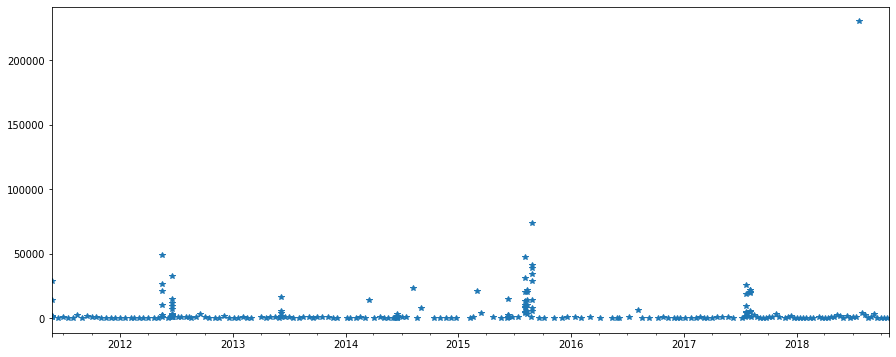

In [11]:
plt.close('all')
data['Ecoli_mpn100'].plot(style="*", figsize=(15, 6))

There is a significant high value of E. coli in the middle of 2018. 

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

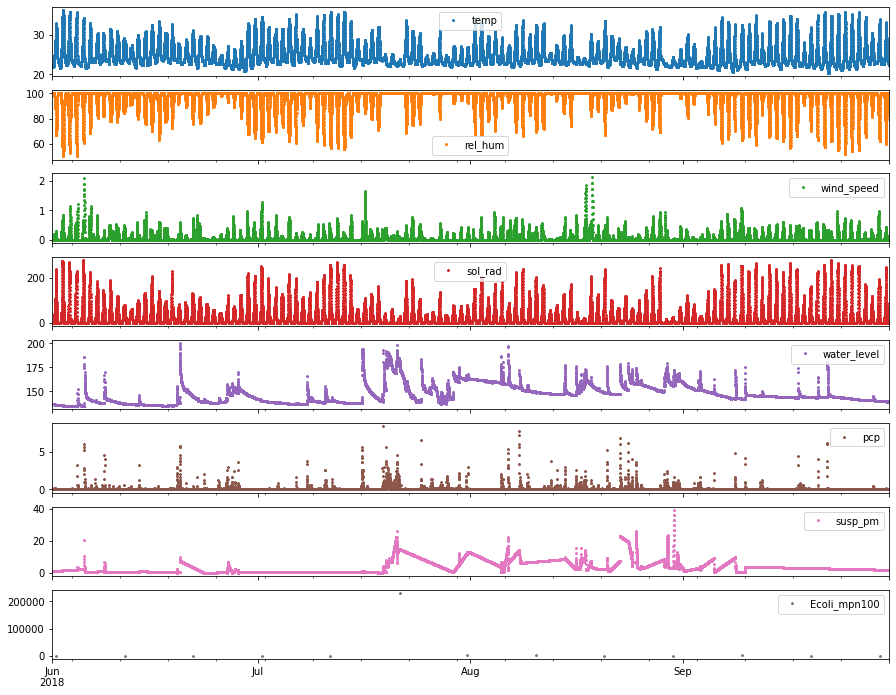

In [12]:
data.loc["20180601":"20180930"].plot(style="*", subplots=True, figsize=(15, 12), ms=2.5)

Among input features, what really changes towards end of July, is the water level. So we would expect that to assert significant influence on model's prediction for this example

In [13]:
model = Model(model="XGBRegressor",
              prefix="ecoli_shap",  # folder name to save results
              val_fraction=0.0,
             )

building ML model for  regression problem using XGBoostRegressor


In [14]:
model.fit(data=data)


********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (206, 7)
target shape:  (206, 1, 1)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


********** Removing Examples with nan in labels  **********

***** Test *****
input_x shape:  (52, 7)
target shape:  (52, 1, 1)


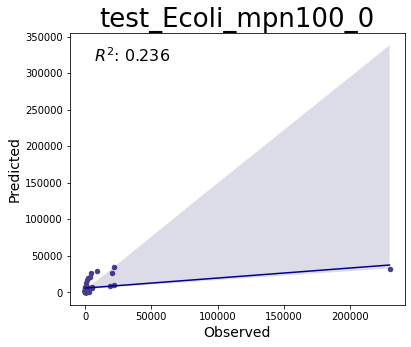

divide by zero encountered in true_divide
divide by zero encountered in log
invalid value encountered in log


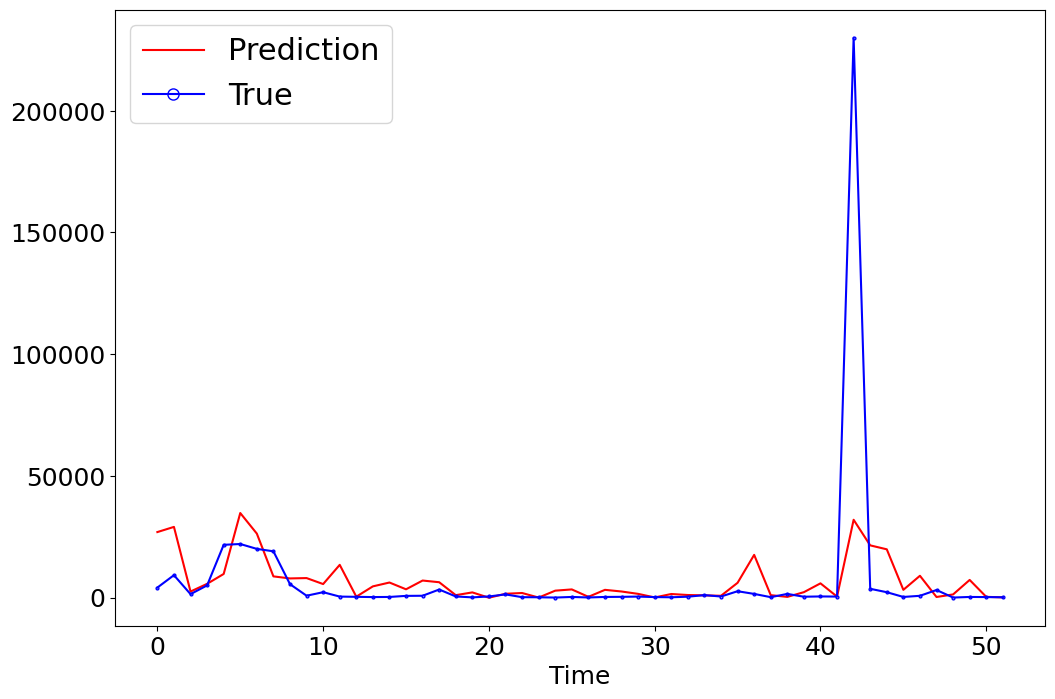

In [15]:
y_true, y_pred = model.predict(return_true=True)

In [16]:
for idx,t,p in zip(range(len(y_true)), y_true, y_pred):
    print(idx, t, p, abs(t.item() - p))

0 [[4100.]] 26905.023 22805.0234375
1 [[9200.]] 29029.021 19829.021484375
2 [[1400.]] 2469.3303 1069.330322265625
3 [[5000.]] 5640.546 640.5458984375
4 [[21666.66666667]] 9696.198 11970.468424479168
5 [[22000.]] 34729.65 12729.6484375
6 [[20000.]] 26273.096 6273.095703125
7 [[19000.]] 8699.292 10300.7080078125
8 [[5500.]] 7859.3813 2359.38134765625
9 [[760.]] 8004.3447 7244.3447265625
10 [[2200.]] 5544.8193 3344.8193359375
11 [[400.]] 13440.901 13040.9013671875
12 [[300.]] 361.81683 61.81683349609375
13 [[200.]] 4597.04 4397.0400390625
14 [[250.]] 6179.1763 5929.17626953125
15 [[690.]] 3394.9224 2704.92236328125
16 [[740.]] 6991.38 6251.3798828125
17 [[3300.]] 6297.485 2997.48486328125
18 [[450.]] 985.02295 535.02294921875
19 [[78.]] 2118.0894 2040.08935546875
20 [[450.]] -66.8688 516.8687973022461
21 [[1300.]] 1553.7823 253.7823486328125
22 [[160.]] 1872.9869 1712.9869384765625
23 [[120.]] -4.3455806 124.34558057785034
24 [[0.]] 2834.7024 2834.702392578125
25 [[250.]] 3344.1562 3094.1

divide by zero encountered in log


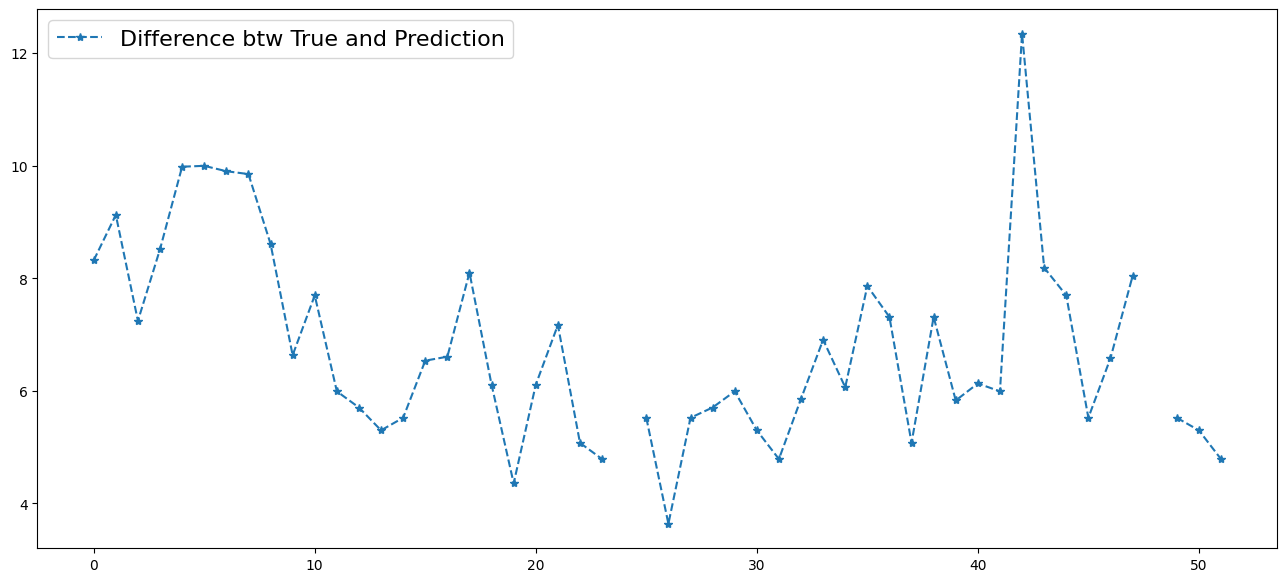

In [17]:
_, axis = plt.subplots(figsize=(16, 7))
axis.plot(np.log(np.absolute(y_true.reshape(-1,), y_pred)), '--*', label="Difference btw True and Prediction")
axis.legend(fontsize=16)

<AxesSubplot:xlabel='Observed', ylabel='Predicted'>

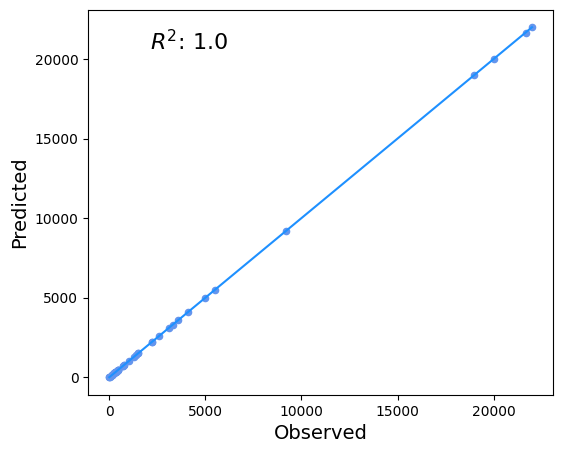

In [18]:
r2 = RegressionMetrics(np.delete(y_true, 42), np.delete(y_pred, 42)).r2()
regplot(np.delete(y_true, 42), np.delete(y_pred, 42), annotation_key="$R^2$", annotation_val=r2)

In [19]:
test_x, test_y = model.test_data()


********** Removing Examples with nan in labels  **********

***** Test *****
input_x shape:  (52, 7)
target shape:  (52, 1, 1)


In [20]:
train_x, train_y = model.training_data()


********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (206, 7)
target shape:  (206, 1, 1)


In [21]:
explainer = LimeExplainer(model,
                          test_x,
                          train_data=train_x, # the data on which model was trained
                          path=model.path,
                          feature_names=model.input_features, # names of features
                          mode=model.mode)

Intercept 1049.0931338173077
Prediction_local [14321.41201254]
Right: 26905.023


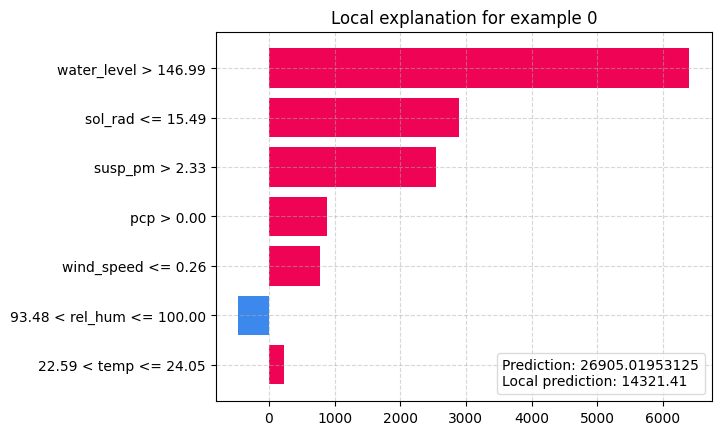

In [22]:
_ = explainer.explain_example(0, annotate=True, show=True, num_samples=10000)

Intercept 5520.338114389866
Prediction_local [2321.4816019]
Right: 2118.0894


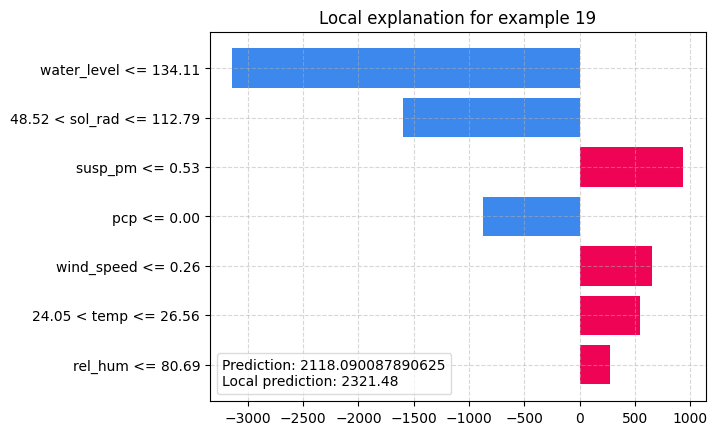

In [23]:
_ = explainer.explain_example(19, annotate=True, show=True)

Intercept 5529.692375063185
Prediction_local [2549.48183992]
Right: 301.39252


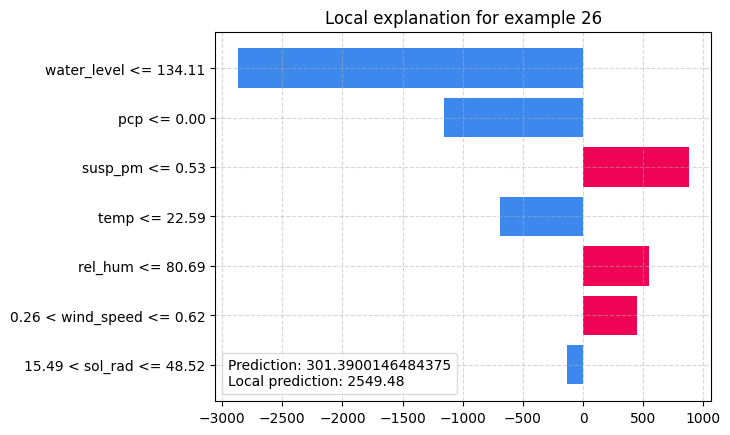

In [24]:
_ = explainer.explain_example(26, annotate=True, show=True)

Intercept 5298.878075990762
Prediction_local [3055.65153037]
Right: 5837.2515


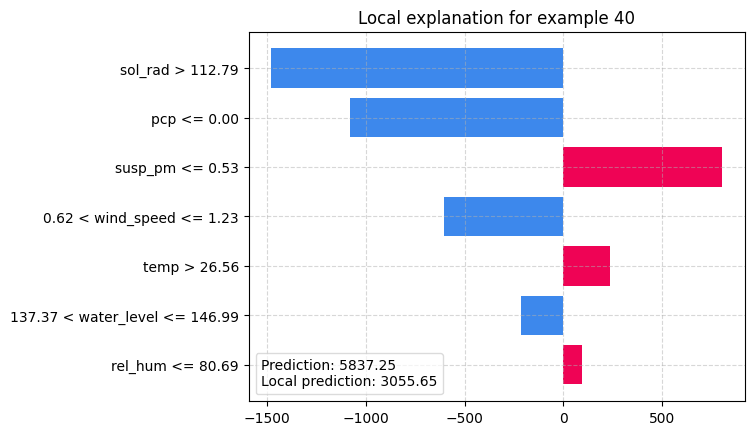

In [25]:
_ = explainer.explain_example(40, annotate=True, show=True)

Intercept 5880.902793610978
Prediction_local [2029.21089653]
Right: 398.87845


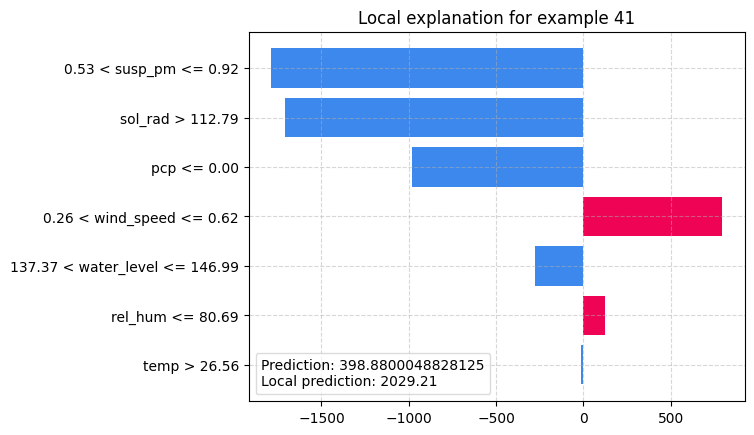

In [26]:
_ = explainer.explain_example(41, annotate=True, show=True)

Intercept 2261.366663747801
Prediction_local [13384.03767542]
Right: 31955.668


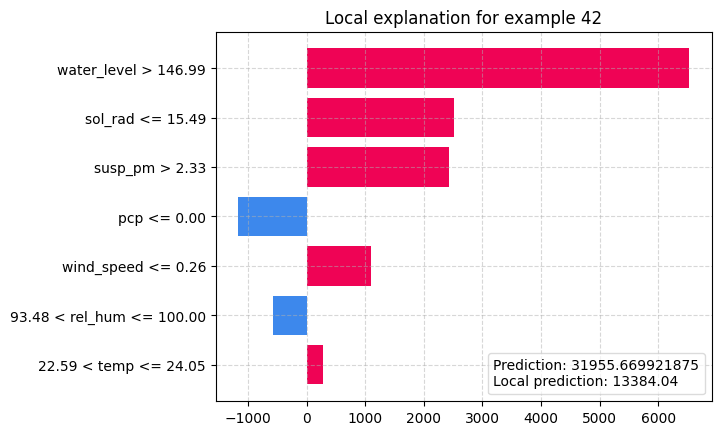

In [27]:
_ = explainer.explain_example(42, annotate=True, show=True)

Intercept 3002.88870386337
Prediction_local [11050.96705005]
Right: 21440.95


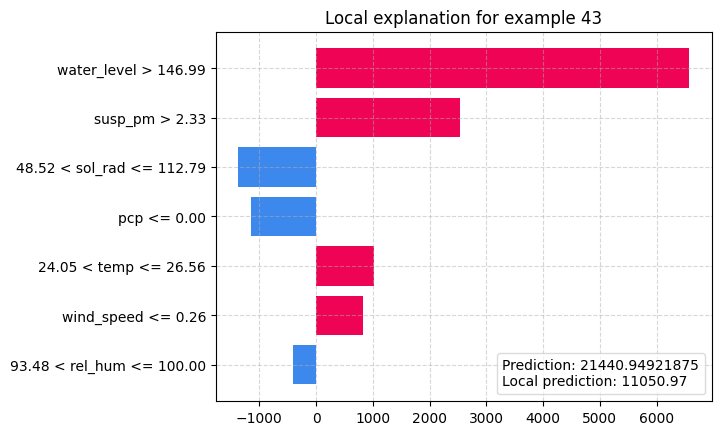

In [28]:
_ = explainer.explain_example(43, annotate=True, show=True)

Intercept 2907.4755678593892
Prediction_local [10279.26083865]
Right: 19820.164


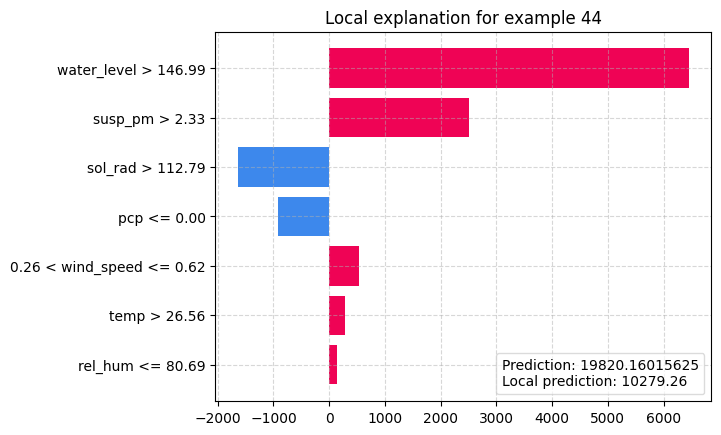

In [29]:
_ = explainer.explain_example(44, annotate=True, show=True)

Intercept 5682.7984248215635
Prediction_local [2388.97169844]
Right: 75.47219


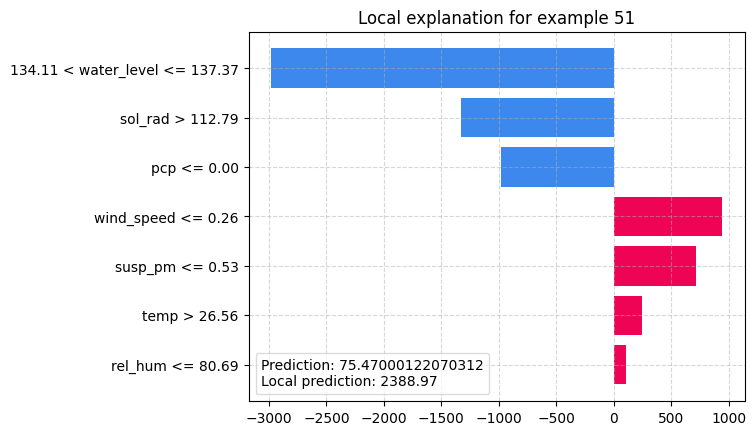

In [30]:
_ = explainer.explain_example(51, annotate=True, show=True)

# Explanation using Training data


********** Removing Examples with nan in labels  **********

***** Training *****
input_x shape:  (206, 7)
target shape:  (206, 1, 1)


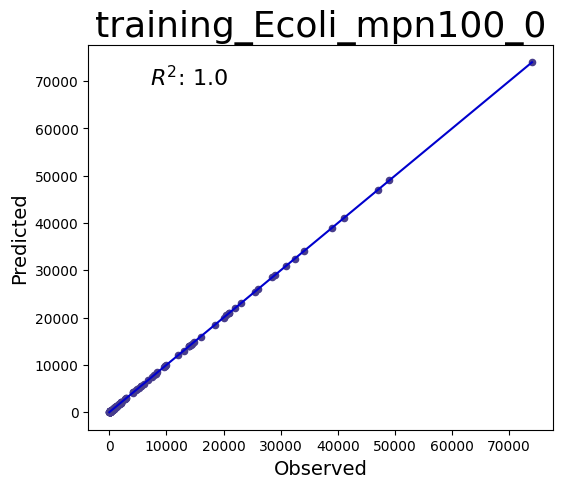

divide by zero encountered in true_divide
divide by zero encountered in log


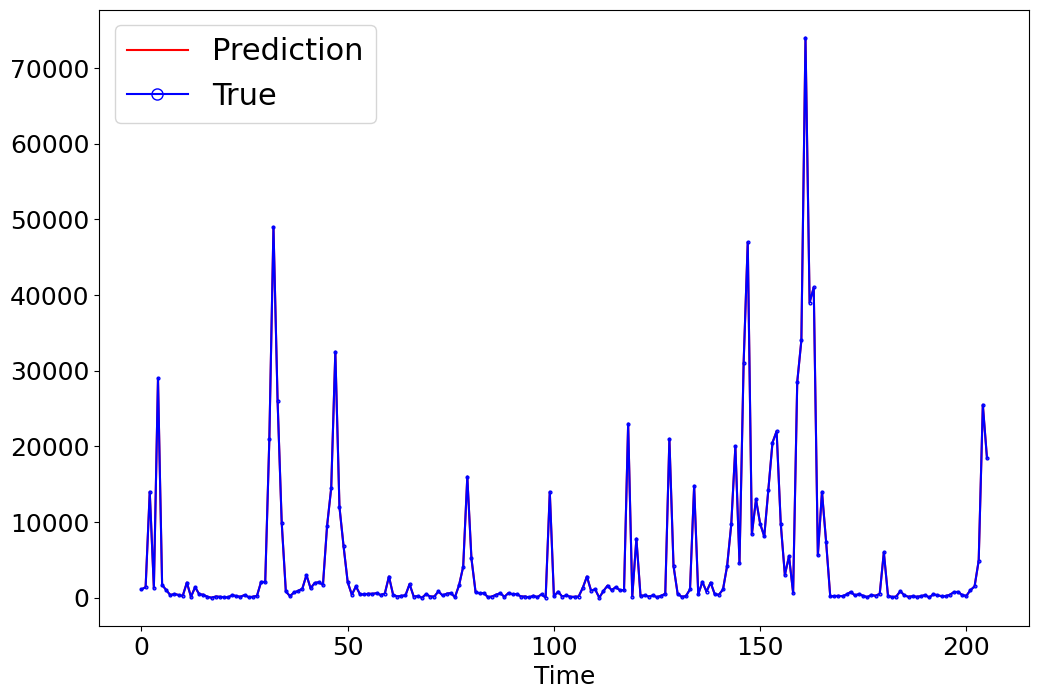

In [31]:
train_y_true, train_y_pred = model.predict('training', return_true=True)

In [32]:
for idx, val in enumerate(train_y_true.reshape(-1,)):
    print(idx, val)

0 1100.0
1 1400.0
2 14000.0
3 1300.0
4 29000.0
5 1700.0
6 1000.0
7 340.0
8 500.0
9 360.0
10 250.0
11 2000.0
12 120.0
13 1400.0
14 460.0
15 390.0
16 120.0
17 0.0
18 160.0
19 120.0
20 78.0
21 38.0
22 350.0
23 210.0
24 120.0
25 360.0
26 78.0
27 120.0
28 250.0
29 2100.0
30 2075.0
31 21000.0
32 49000.0
33 26000.0
34 9900.0
35 830.0
36 210.0
37 700.0
38 900.0
39 1200.0
40 3000.0
41 1250.0
42 1950.0
43 2050.0
44 1700.0
45 9500.0
46 14500.0
47 32500.0
48 12000.0
49 6800.0
50 2050.0
51 400.0
52 1500.0
53 430.0
54 440.0
55 530.0
56 510.0
57 600.0
58 360.0
59 550.0
60 2800.0
61 410.0
62 160.0
63 250.0
64 300.0
65 1800.0
66 160.0
67 210.0
68 0.0
69 470.0
70 160.0
71 160.0
72 840.0
73 300.0
74 530.0
75 620.0
76 78.0
77 1650.0
78 4100.0
79 16000.0
80 5200.0
81 760.0
82 570.0
83 620.0
84 78.0
85 160.0
86 400.0
87 600.0
88 120.0
89 630.0
90 450.0
91 490.0
92 160.0
93 160.0
94 38.0
95 260.0
96 78.0
97 450.0
98 0.0
99 14000.0
100 200.0
101 800.0
102 160.0
103 300.0
104 120.0
105 120.0
106 160.0
107 1310

FixedFormatter should only be used together with FixedLocator


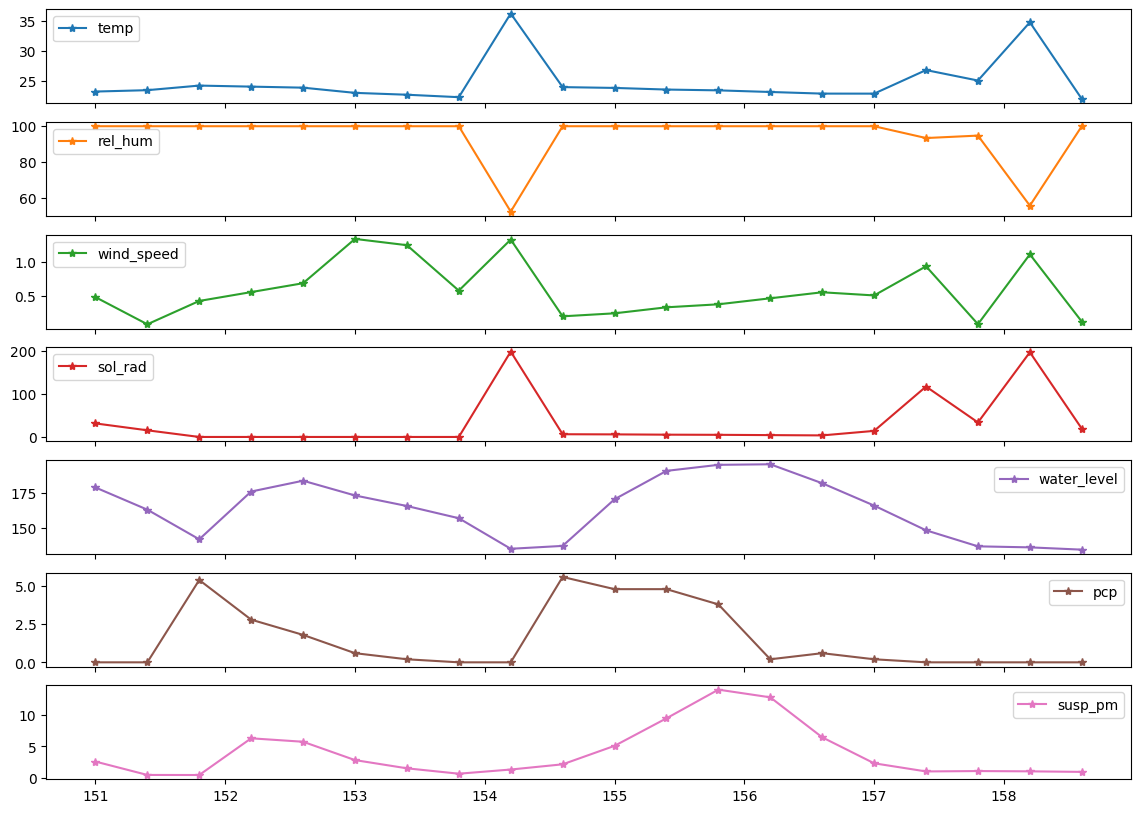

In [33]:
axis = pd.DataFrame(train_x[150:170], columns=model.config['input_features']).plot(subplots=True, 
                                                                  figsize=(14, 10),
                                                                 style="-*")

for ax in axis.flat:
    ax.set_xticklabels(range(150, 170))

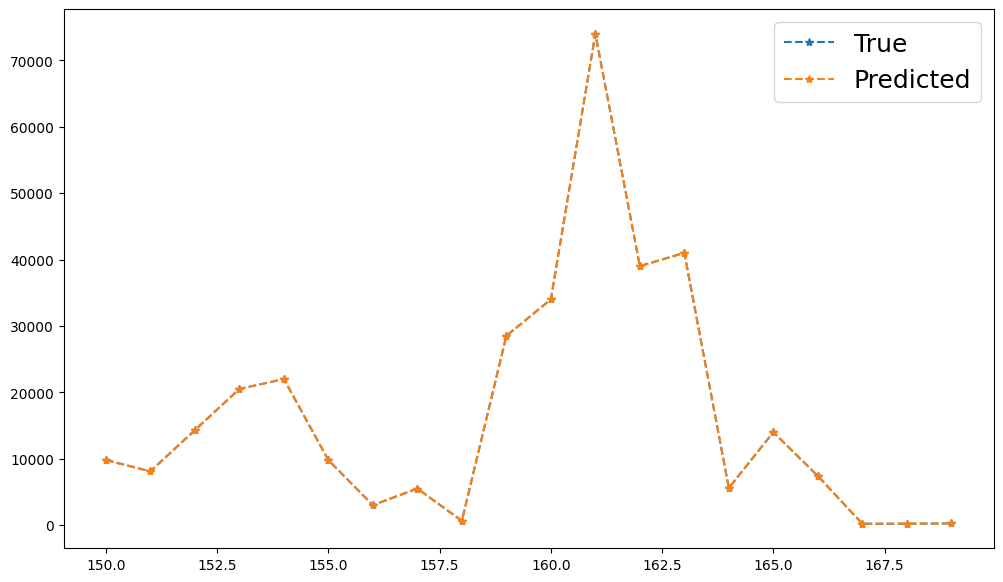

In [34]:
_, axis= plt.subplots(figsize=(12, 7))
axis.plot(range(150, 170), train_y_true[150:170].reshape(-1,), "--*", label="True")
axis.plot(range(150, 170), train_y_pred[150:170], "--*", label="Predicted")
axis.legend(fontsize=18)

In [1]:
explainer = LimeExplainer(model,
                          train_x,
                          train_data=train_x, # the data on which model was trained
                          path=model.path,
                          feature_names=model.input_features, # names of features
                          mode=model.mode)

NameError: name 'LimeExplainer' is not defined

Intercept 5565.700140780912
Prediction_local [2569.81283993]
Right: 1092.5492


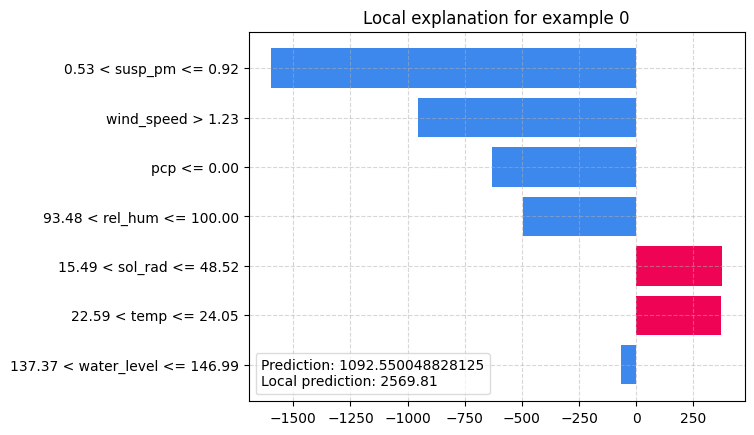

In [36]:
_ = explainer.explain_example(0, annotate=True, show=True)

Intercept 2861.707514210192
Prediction_local [8987.7602855]
Right: 3003.6333


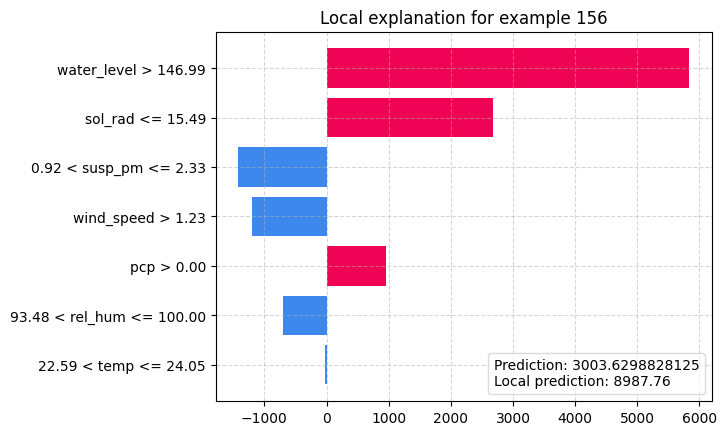

Intercept 3505.739104496984
Prediction_local [9159.92078343]
Right: 5501.4775


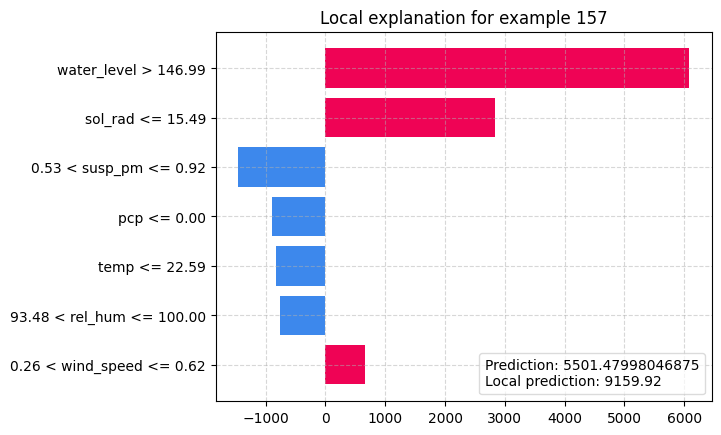

Intercept 6692.926476582117
Prediction_local [-815.72370681]
Right: 646.32715


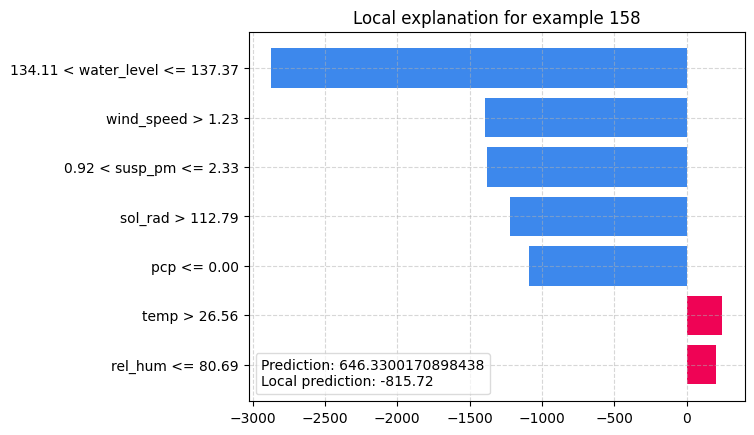

Intercept 4231.596129249057
Prediction_local [4583.12209963]
Right: 28496.117


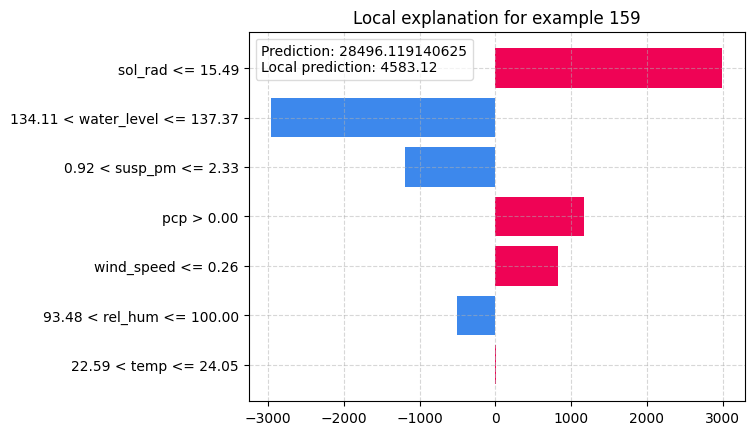

Intercept 1274.3335545922614
Prediction_local [13927.87013425]
Right: 34004.38


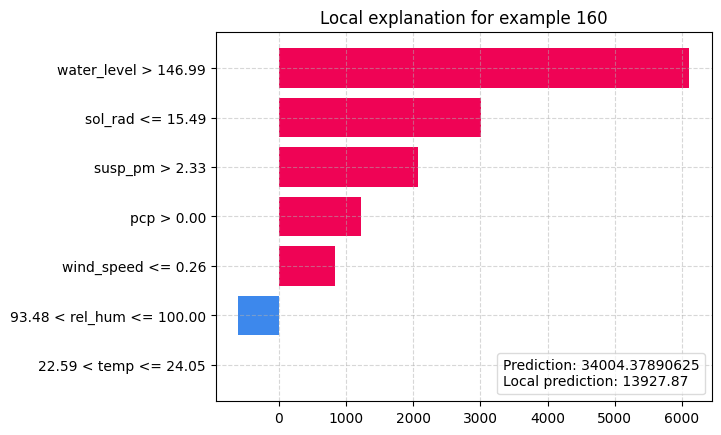

Intercept 1151.7042394338719
Prediction_local [13993.05742561]
Right: 73989.22


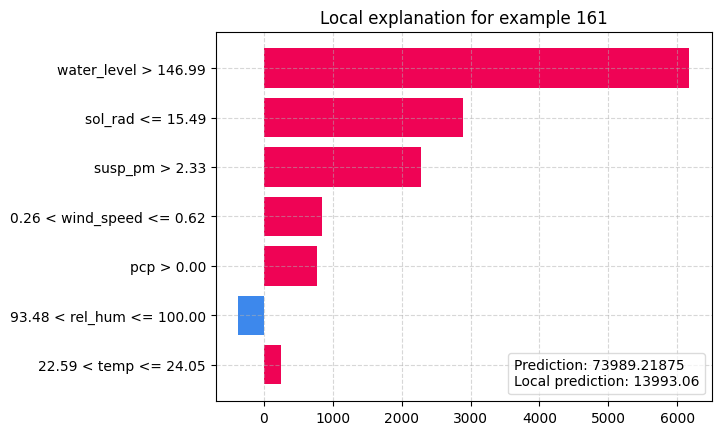

Intercept 1106.4484827202173
Prediction_local [14015.82920592]
Right: 39006.48


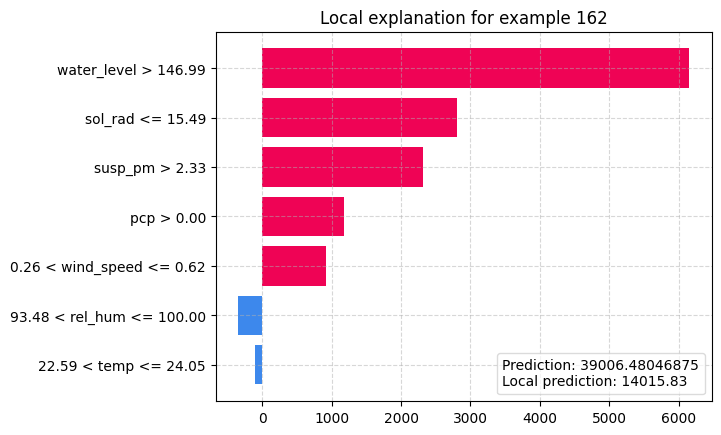

In [37]:
for i in range(156, 163):
    _ = explainer.explain_example(i, annotate=True, show=True)

FixedFormatter should only be used together with FixedLocator


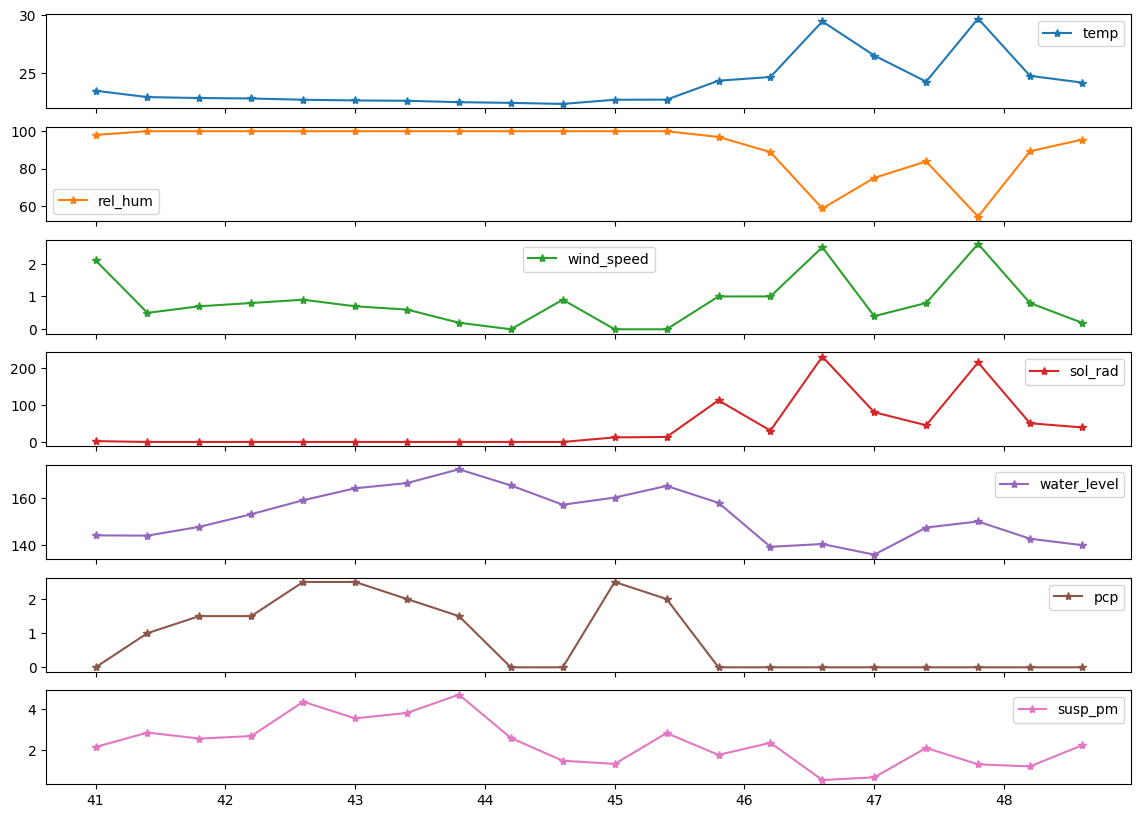

In [38]:

axis = pd.DataFrame(train_x[40:60],
             columns=model.config['input_features']).plot(subplots=True,
                                                          figsize=(14, 10),
                                                          style="-*")
for ax in axis.flat:
    ax.set_xticklabels(range(40, 60))

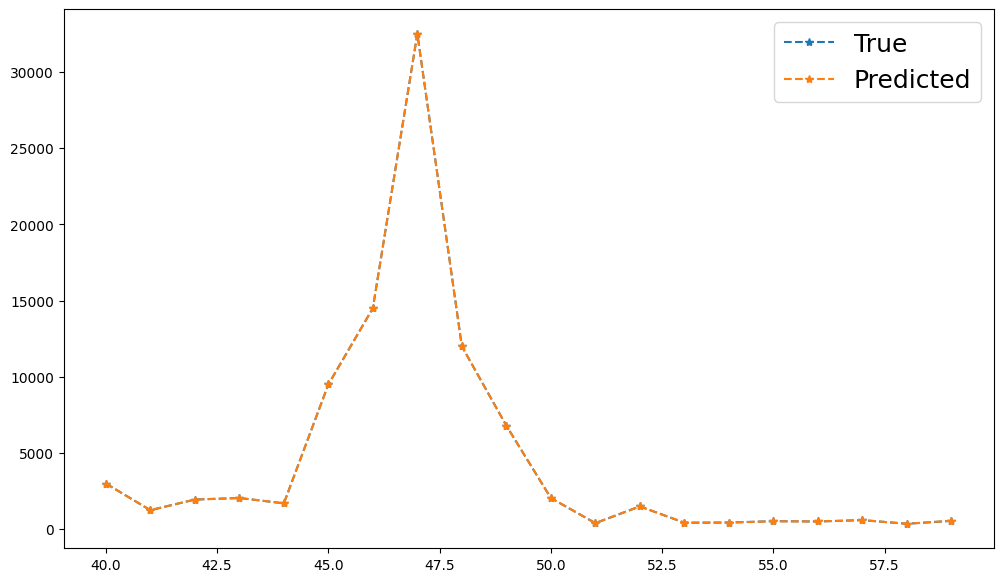

In [39]:
_, axis= plt.subplots(figsize=(12, 7))
axis.plot(range(40, 60), train_y_true[40:60].reshape(-1,), "--*", label="True")
axis.plot(range(40, 60), train_y_pred[40:60], "--*", label="Predicted")
axis.legend(fontsize=18)

Intercept 1500.3343145792664
Prediction_local [12857.37673098]
Right: 9496.173


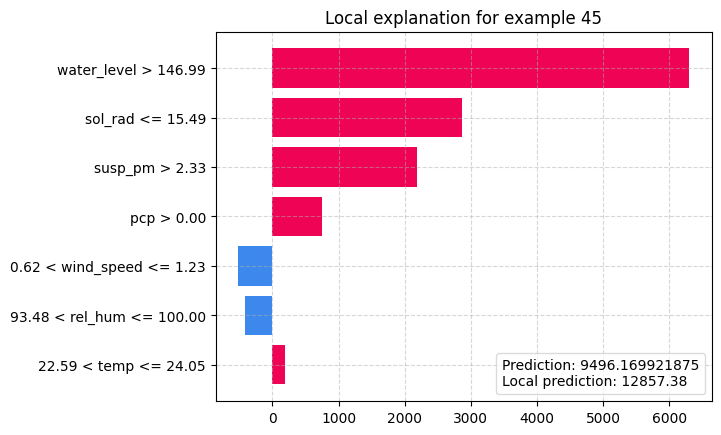

Intercept 1414.9322452271772
Prediction_local [13117.65861921]
Right: 14497.167


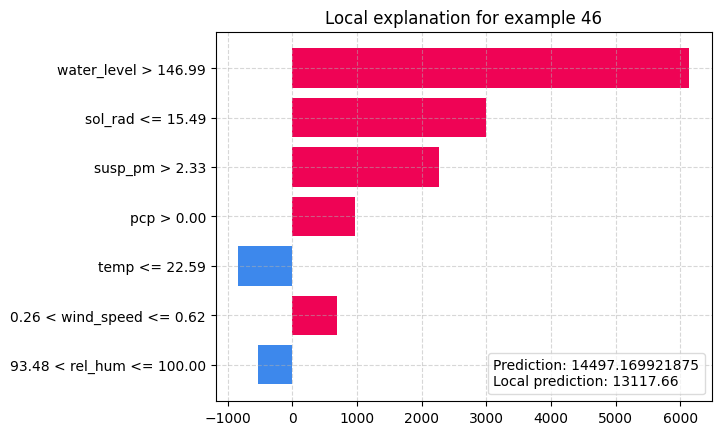

Intercept 1274.463707800911
Prediction_local [13539.29610713]
Right: 32498.135


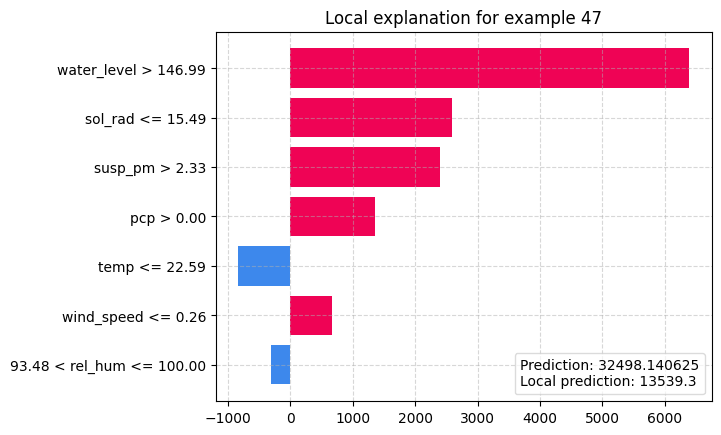

Intercept 2496.661317253167
Prediction_local [12157.41629839]
Right: 12000.423


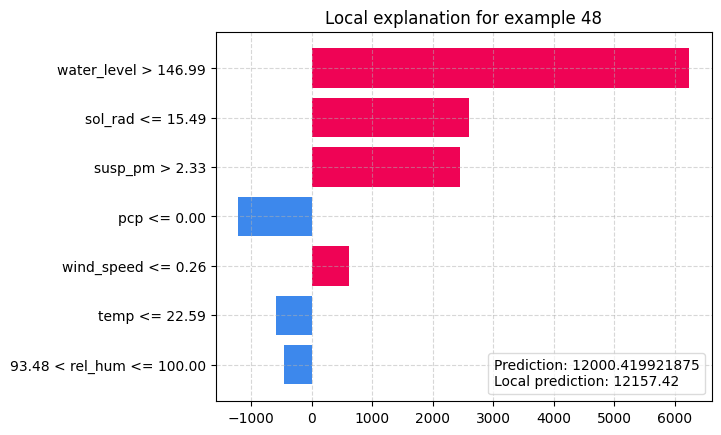

Intercept 3850.182630740684
Prediction_local [8184.69218147]
Right: 6788.77


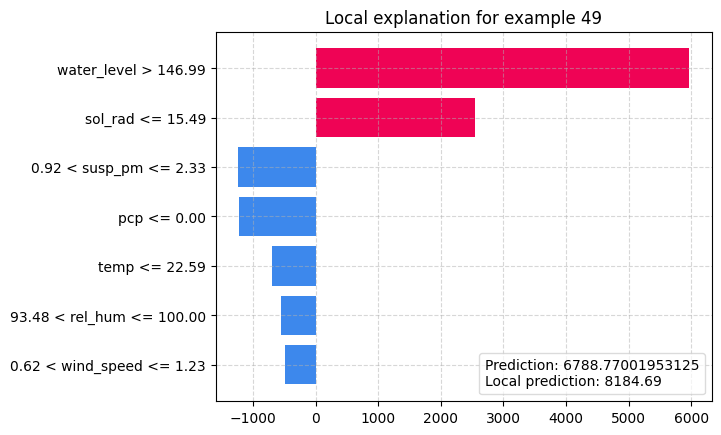

Intercept 2058.527929362389
Prediction_local [11405.24284791]
Right: 2051.0945


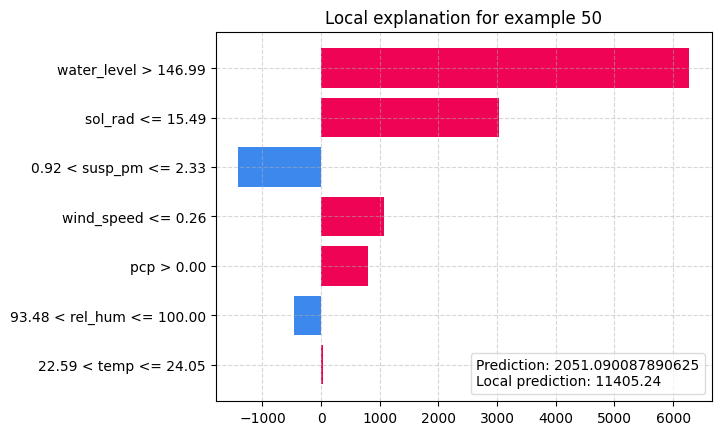

Intercept 999.0449474019106
Prediction_local [14937.33081369]
Right: 404.56372


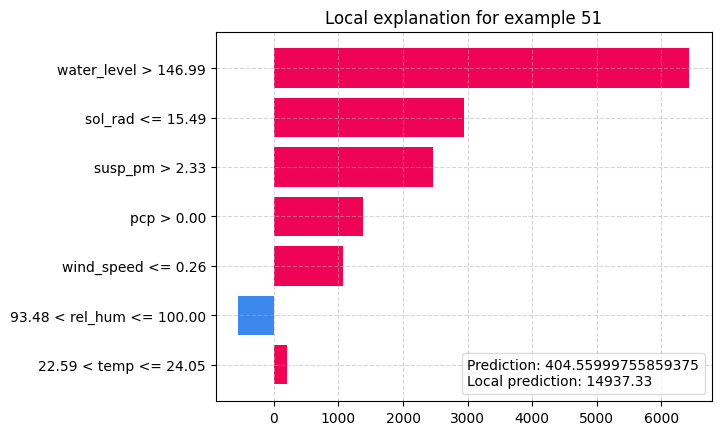

Intercept 4476.82193588239
Prediction_local [6011.73433756]
Right: 1499.8114


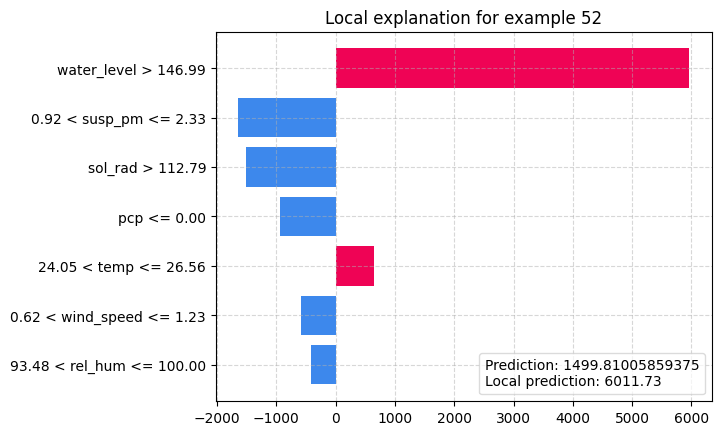

Intercept 4493.253180055845
Prediction_local [5438.45900097]
Right: 436.4533


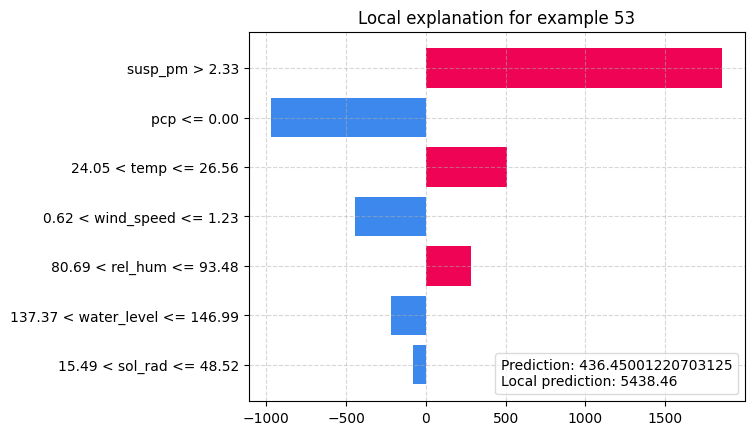

Intercept 5886.497779533313
Prediction_local [1366.25224116]
Right: 440.75012


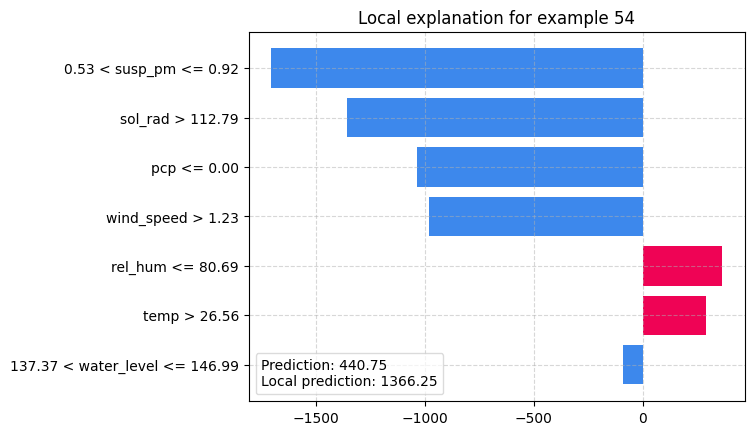

In [40]:
for i in range(45, 55):
    _ = explainer.explain_example(i, annotate=True, show=True)

FixedFormatter should only be used together with FixedLocator


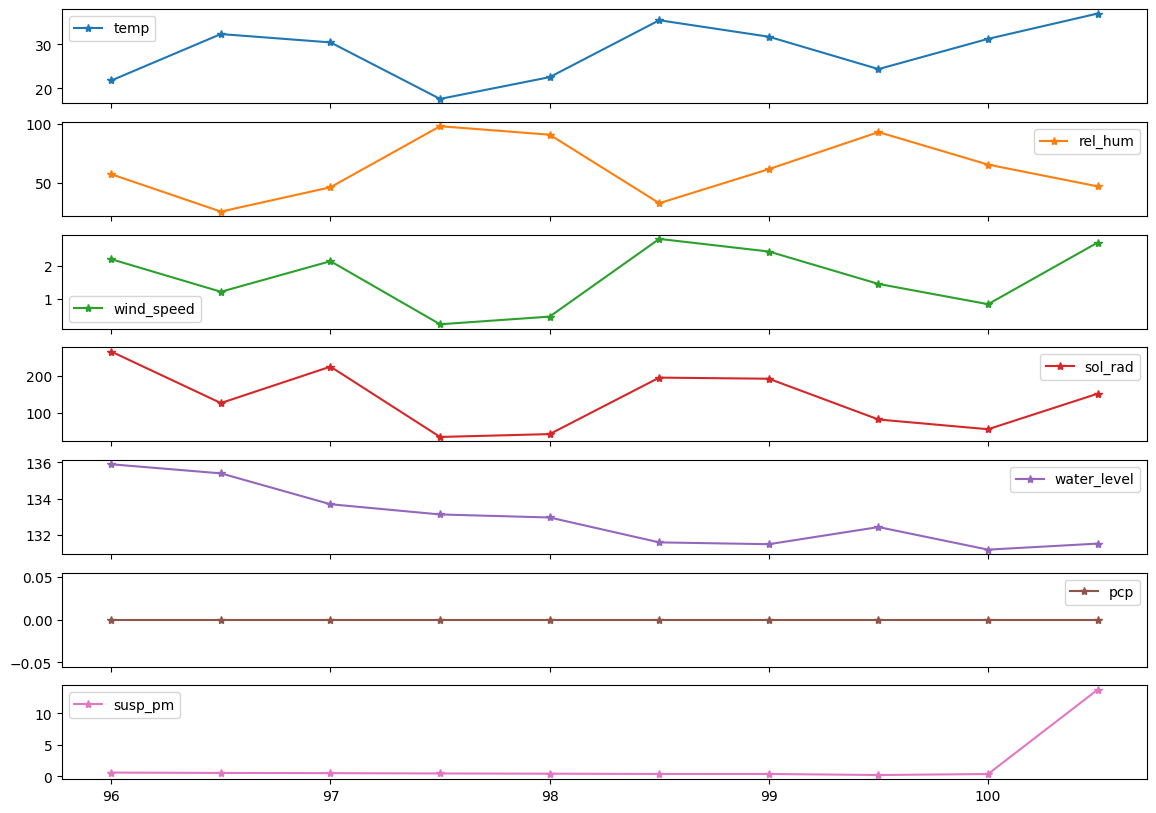

In [41]:
st, en = 95, 105
axis = pd.DataFrame(train_x[st:en],
             columns=model.config['input_features']).plot(subplots=True,
                                                          figsize=(14, 10),
                                                          style="-*")
for ax in axis.flat:
    ax.set_xticklabels(range(st, en))

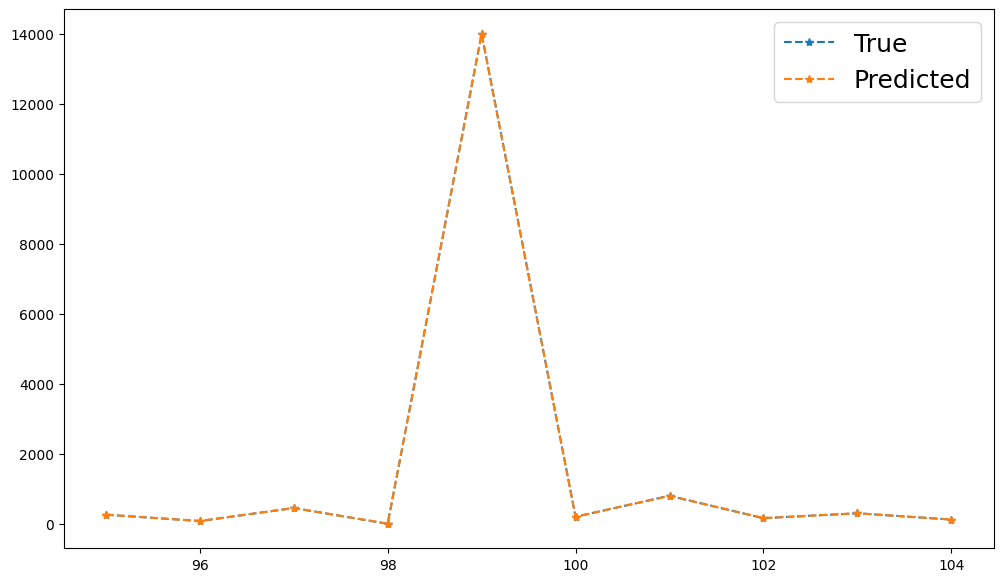

In [42]:
_, axis= plt.subplots(figsize=(12, 7))
axis.plot(range(st, en), train_y_true[st:en].reshape(-1,), "--*", label="True")
axis.plot(range(st, en), train_y_pred[st:en], "--*", label="Predicted")
axis.legend(fontsize=18)

Intercept 6890.253149749581
Prediction_local [-1490.80847038]
Right: 259.33722


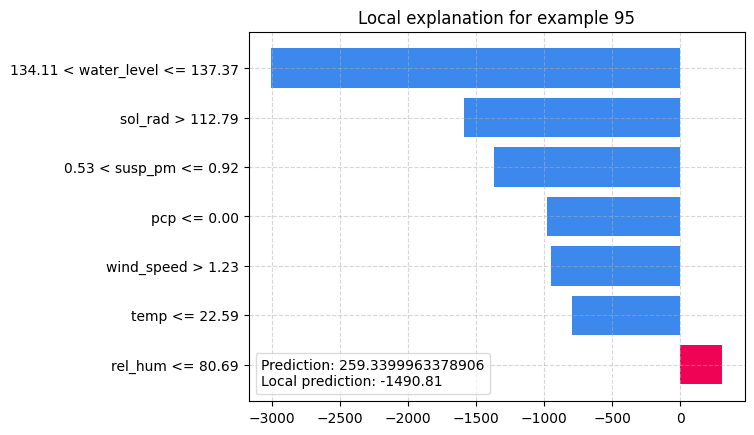

Intercept 6511.093484621622
Prediction_local [-236.41528356]
Right: 79.628174


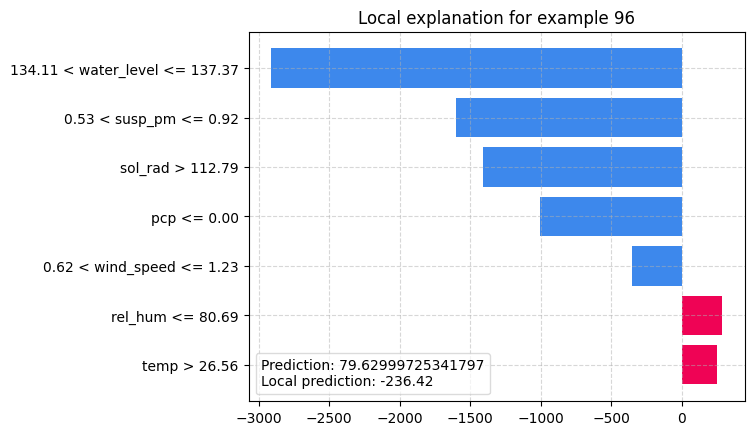

Intercept 6179.950145373006
Prediction_local [1065.55798486]
Right: 450.27814


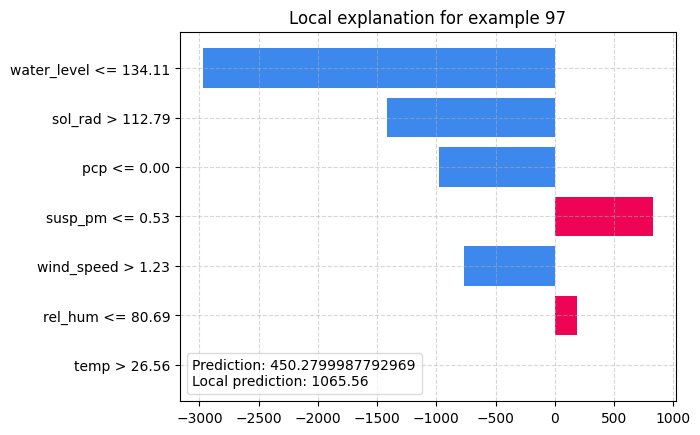

Intercept 5854.267898099637
Prediction_local [2195.08691623]
Right: 3.3112009


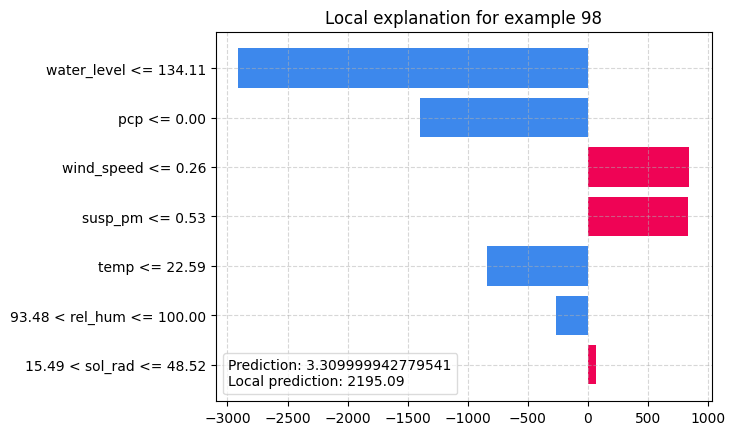

Intercept 5489.5938249416495
Prediction_local [2650.85115511]
Right: 13990.932


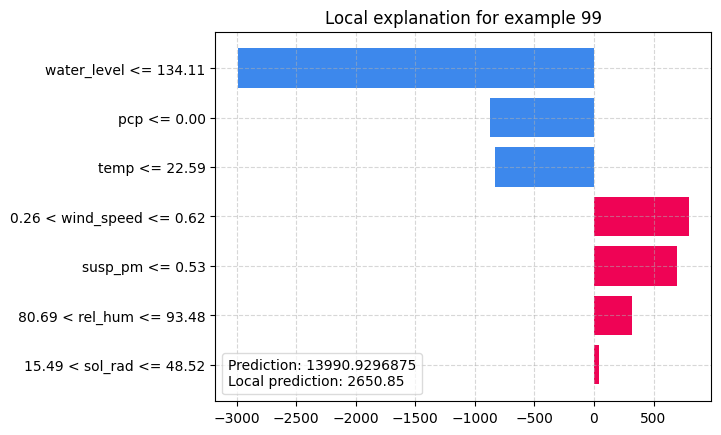

Intercept 5915.291940125977
Prediction_local [715.67251712]
Right: 201.52237


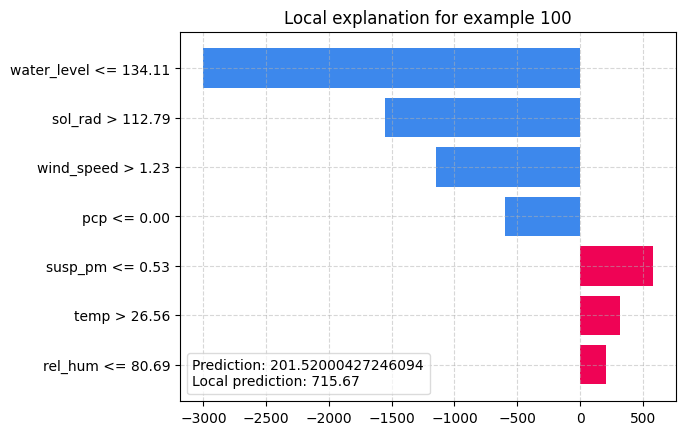

Intercept 5975.434999604678
Prediction_local [658.37109988]
Right: 796.4161


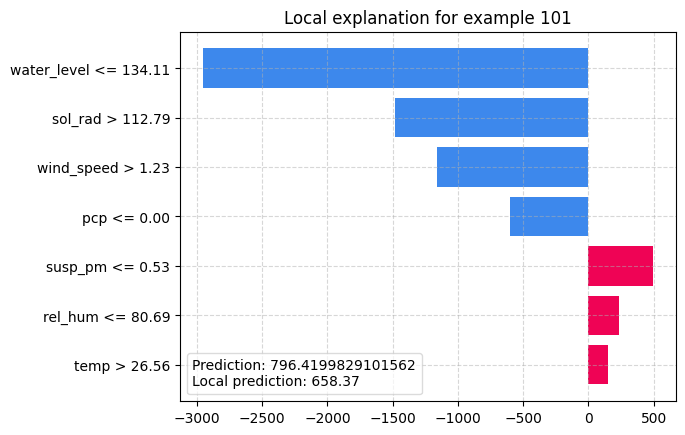

Intercept 6004.587583958686
Prediction_local [854.30861047]
Right: 161.61528


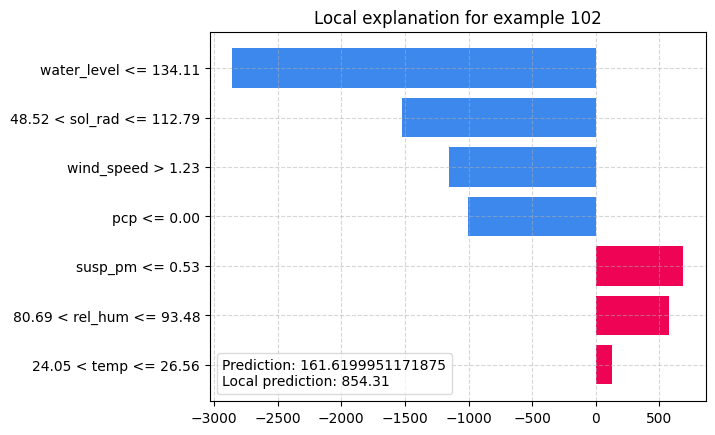

Intercept 5771.527085076321
Prediction_local [1410.63564431]
Right: 300.14468


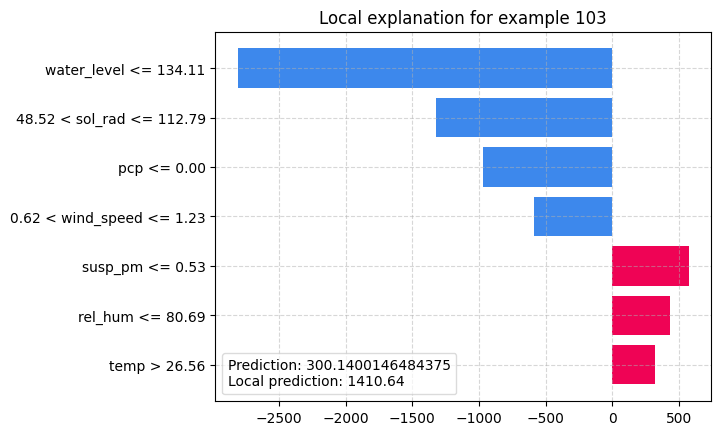

Intercept 5641.531313223917
Prediction_local [1952.61507262]
Right: 120.39594


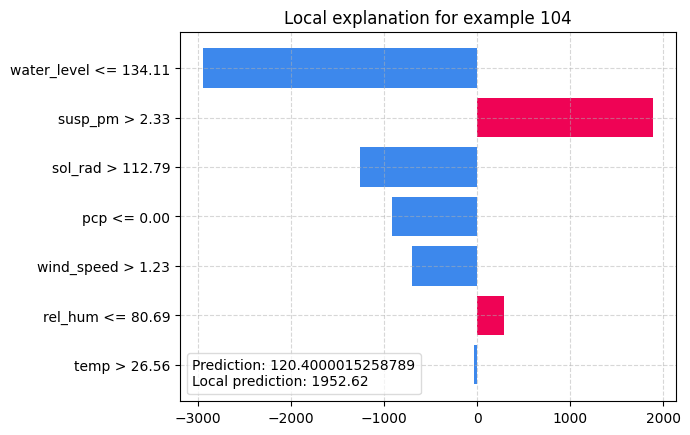

In [43]:
for i in range(st, en):
    _ = explainer.explain_example(i, annotate=True, show=True)

FixedFormatter should only be used together with FixedLocator


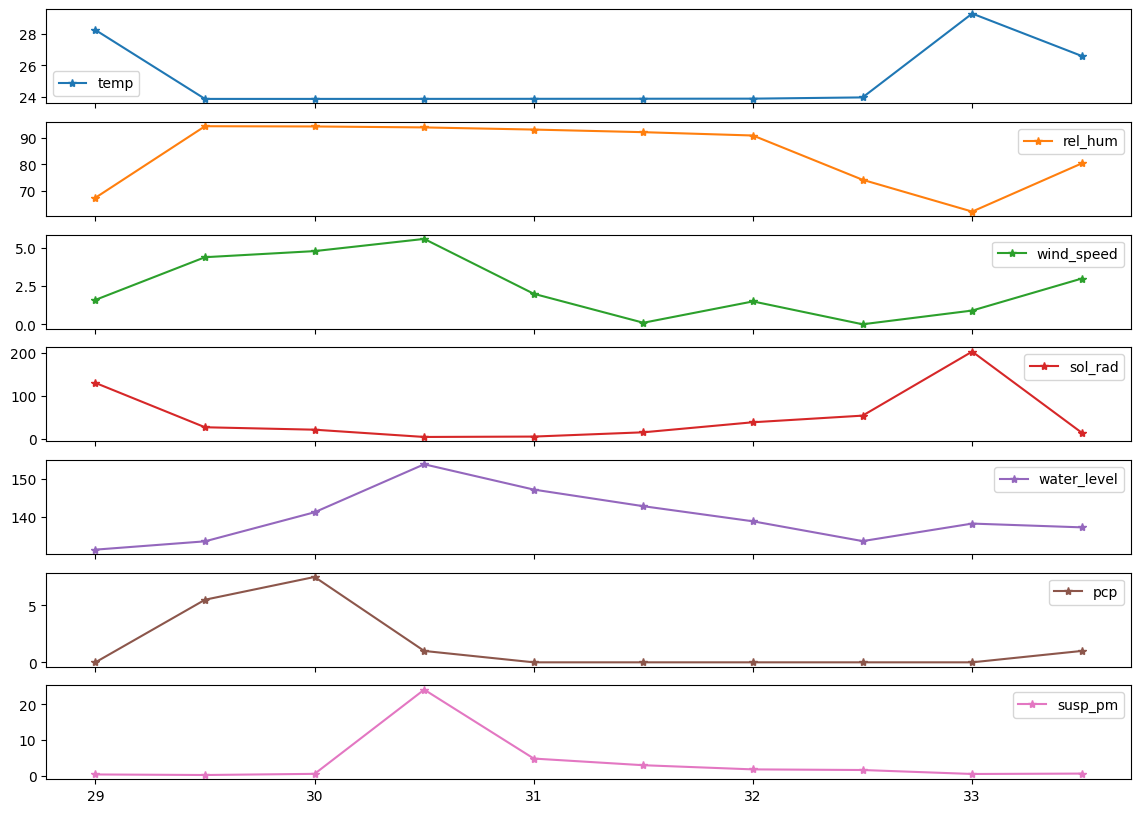

In [44]:
st, en = 28, 38
axis = pd.DataFrame(train_x[st:en],
             columns=model.config['input_features']).plot(subplots=True,
                                                          figsize=(14, 10),
                                                          style="-*")
for ax in axis.flat:
    ax.set_xticklabels(range(st, en))

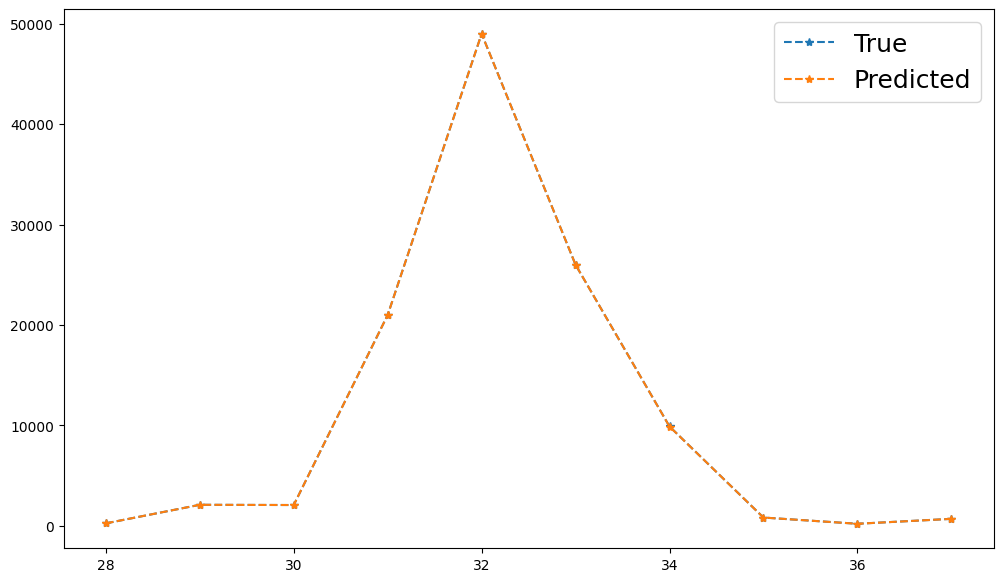

In [45]:
_, axis= plt.subplots(figsize=(12, 7))
axis.plot(range(st, en), train_y_true[st:en].reshape(-1,), "--*", label="True")
axis.plot(range(st, en), train_y_pred[st:en], "--*", label="Predicted")
axis.legend(fontsize=18)

Intercept 6241.780775247742
Prediction_local [986.13731482]
Right: 251.18839


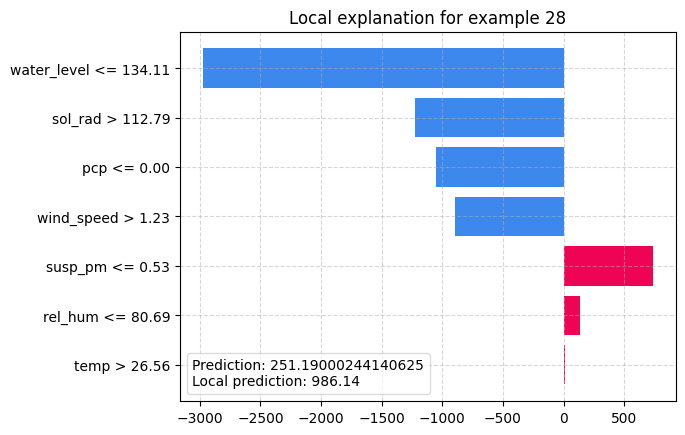

Intercept 5162.690761270686
Prediction_local [2213.73582328]
Right: 2098.4324


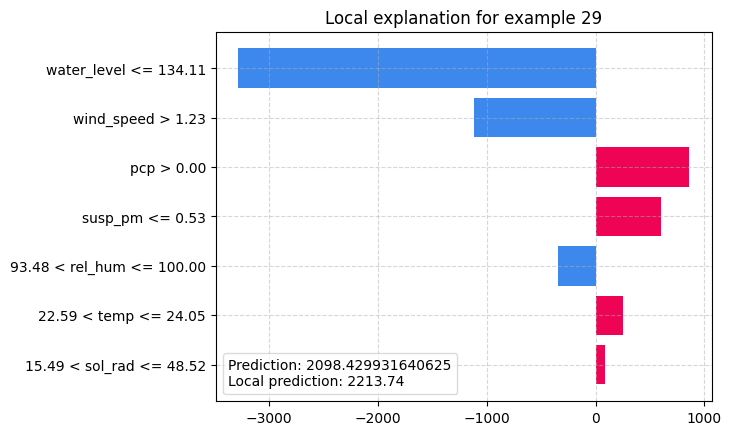

Intercept 5168.036553668193
Prediction_local [2845.42319754]
Right: 2076.4973


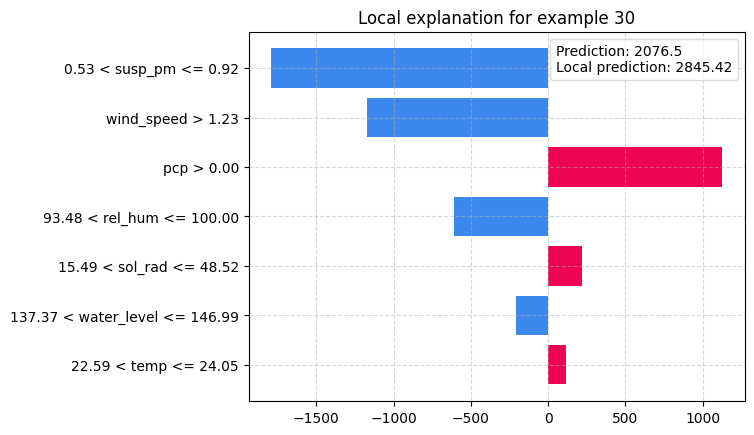

Intercept 1808.0963290997674
Prediction_local [12147.042657]
Right: 20998.479


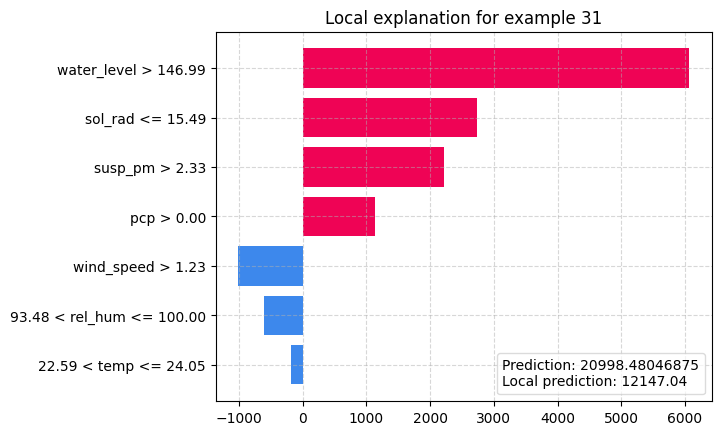

Intercept 2222.911949209505
Prediction_local [12621.35215213]
Right: 49000.254


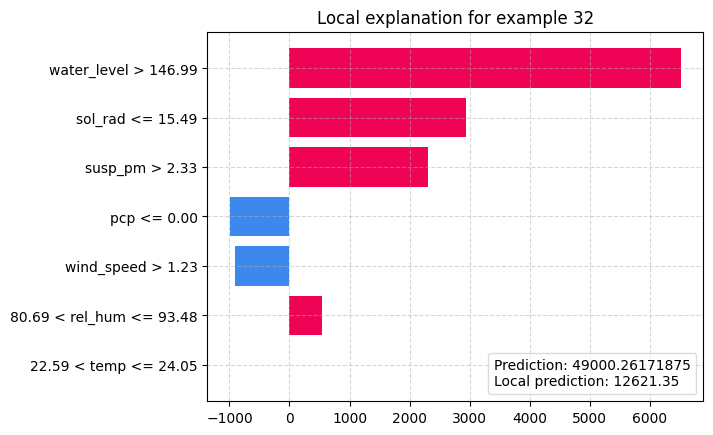

Intercept 3407.9405032863833
Prediction_local [9096.93470133]
Right: 26000.309


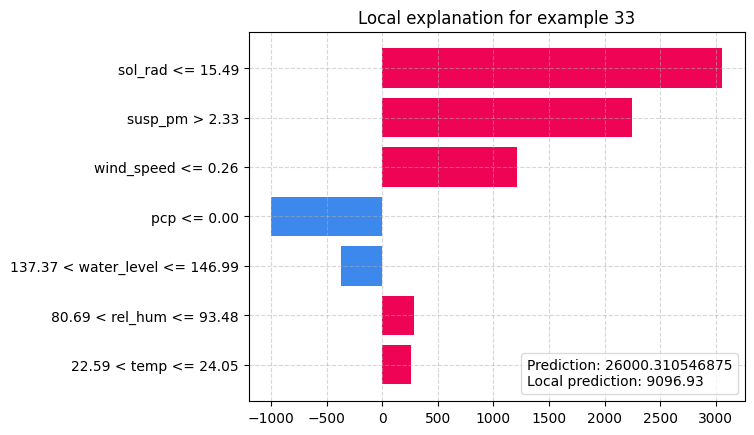

Intercept 5752.016916375371
Prediction_local [2395.12887385]
Right: 9892.555


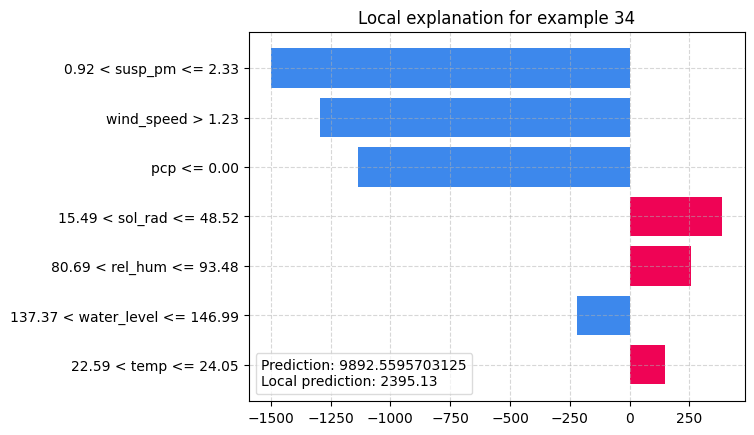

Intercept 6194.05375697064
Prediction_local [59.02460146]
Right: 829.3118


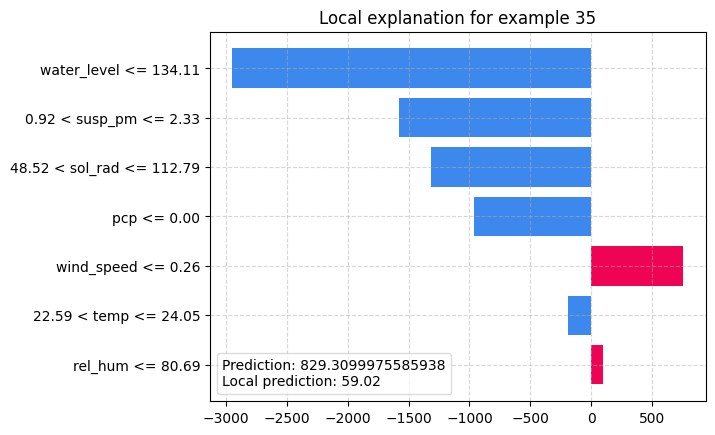

Intercept 5437.766144580262
Prediction_local [3453.76076092]
Right: 208.85713


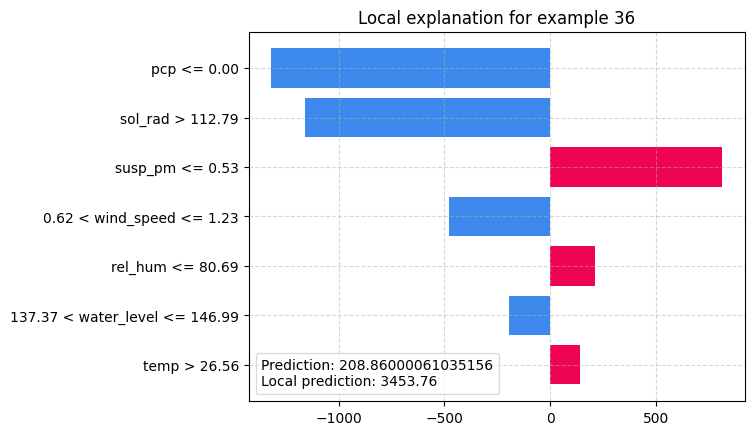

Intercept 4782.133692159122
Prediction_local [2973.27593345]
Right: 698.49854


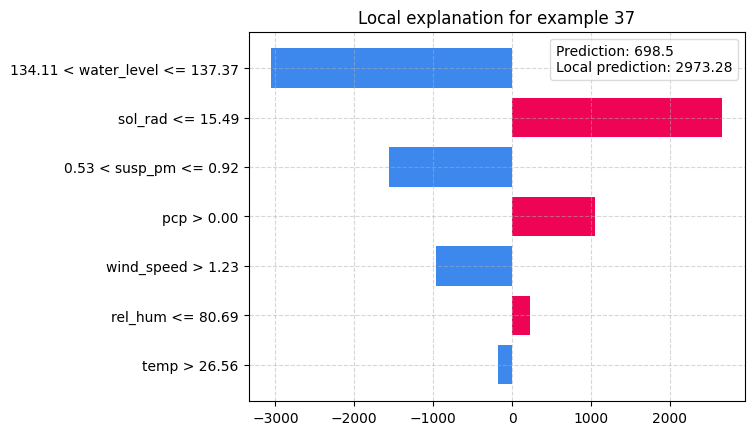

In [46]:
for i in range(st, en):
    _ = explainer.explain_example(i, annotate=True, show=True)